In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (7, 7)

In [2]:
X = pd.read_csv("../data/features_train.csv")
y = pd.read_csv("../data/classes_train.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, shuffle=True)

## 1. Базовый контест

### 1.1. Обучить модель без каких-либо дополнительных условий, которая должна наилучшим образом отработать на тестовой выборке преподавателя с точки зрения F-меры

In [4]:
# Градиентный бустинг
model_XGB = xgb.XGBClassifier()
model_XGB.fit(X_train, y_train)
predict_XGB = model_XGB.predict(X_test)

In [5]:
# Стохастический градиентный спуск
model_SGD = SGDClassifier()
model_SGD.fit(X_train, y_train)
predict_SGD = model_SGD.predict(X_test)

In [6]:
# Классификатор с помощью регрессии Ridge
model_Ridge = RidgeClassifier()
model_Ridge.fit(X_train, y_train)
predict_Ridge = model_Ridge.predict(X_test)

In [7]:
# Наивный Байес
model_BernoulliNB = BernoulliNB()
model_BernoulliNB.fit(X_train, y_train)
predict_BernoulliNB = model_BernoulliNB.predict(X_test)

In [8]:
# Дерево решений
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_train, y_train)
predict_DTC = model_DTC.predict(X_test)

#### 1.1.1 Результаты

In [9]:
pd.DataFrame(data=[f1_score(y_test, predict_XGB), f1_score(y_test, predict_DTC),
                   f1_score(y_test, predict_SGD), f1_score(y_test, predict_Ridge),
                   f1_score(y_test, predict_BernoulliNB)],
             columns=['F1-Score'],
             index=['XGB', 'DTC', 'SGD', 'Ridge', 'NB']).sort_values('F1-Score', ascending=False)

,F1-Score
XGB,0.993220
DTC,0.989831
Ridge,0.984925
NB,0.981697
SGD,0.914077


In [10]:
# сохранение лучшей модели
with open('../models/model_XGB_1_1.pkl','wb') as f:
    pickle.dump(model_XGB, f)

#### 1.1.2 Вывод

Исходя из результатов, видно, что лучшей моделью по F-мере из пяти выбранных стал ```XGBoost``` или градиентный бустинг.

## 2. Вторичные контесты

### 2.1. Максимально логичным образом обучить качественную модель, использующую для работы только 10 признаков из всего исходного множества.

In [11]:
# по умолчанию параметры SelectKBest(score_func=f_classif, k=10)
k_best = SelectKBest()
fit = k_best.fit(X_train, y_train)

In [12]:
# формируем датафрейм с наиболее информативными признаками 
pd.DataFrame(data={'Feature': X_train.columns, 'f_classif_score': fit.scores_})\
            .sort_values('f_classif_score', ascending=False).head(10)

,Feature,f_classif_score
7,is_verified,33760.513542
8,user_age,2695.216594
5,is_default_profile,110.408138
3,favourites_count,86.234281
6,is_profile_use_background_image,75.527409
12,favourites_growth_rate,67.001042
19,description_length,49.885589
2,friends_count,38.217795
11,friends_growth_rate,37.192874
15,screen_name_length,35.024428


In [13]:
# выбор наиболее информативных признаков
X_kbest = X[['is_verified', 'user_age', 'is_default_profile', 'favourites_count',
             'is_profile_use_background_image', 'favourites_growth_rate', 'description_length',
             'friends_count', 'friends_growth_rate', 'screen_name_length']]

In [14]:
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_kbest, y, test_size=0.5, random_state=1, shuffle=True)

In [15]:
# обучаем наилучшую модель из п.1
model_XGB_k = xgb.XGBClassifier()
model_XGB_k.fit(X_train_k, y_train_k)
predict_XGB_k = model_XGB_k.predict(X_test_k)

#### 2.1.1 Результаты

In [16]:
print("F1-Score с SelectKBest: %.8s" %f1_score(y_test_k, predict_XGB_k))

F1-Score с SelectKBest: 0.989795


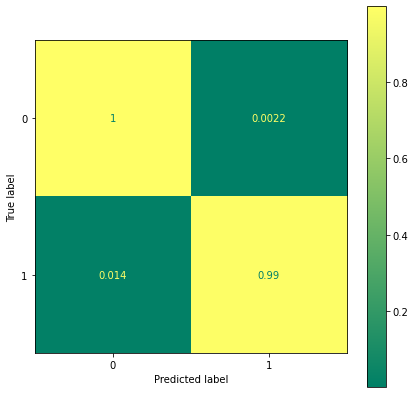

In [17]:
plot_confusion_matrix(model_XGB_k, X_test_k, y_test_k, normalize='true', cmap='summer')
plt.show()

In [18]:
# сохранение модели
with open('../models/model_XGB_2_1.pkl','wb') as f:
    pickle.dump(model_XGB_k, f)

### 2.2. Обучить модель, обеспечивающую вероятность пропуска бота на уровне не выше 0.03, и имеющую насколько возможно низкую вероятность ложного обнаружения.

In [19]:
# обучаем наилучшую модель из п.1
model_XGB_2_2 = xgb.XGBClassifier()
model_XGB_2_2.fit(X_train, y_train)
predict_XGB_2_2 = model_XGB_2_2.predict(X_test)

#### 2.2.1 Результаты

In [20]:
print("F1-Score: %.8s" %f1_score(y_test, predict_XGB_2_2))

F1-Score: 0.993220


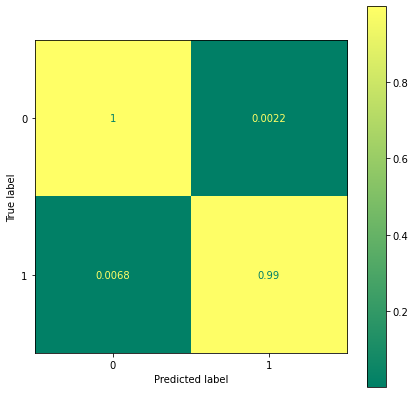

In [21]:
plot_confusion_matrix(model_XGB_2_2, X_test, y_test, normalize='true', cmap='summer')
plt.show()

In [22]:
# сохранение модели
with open('../models/model_XGB_2_2.pkl','wb') as f:
    pickle.dump(model_XGB_2_2, f)

### 2.3 Вывод

Исходя из полученных результатов, можно сделать вывод, что ```feature_selection``` не всегда положительно сказывается на качестве модели, так как модели сложно восстановить зависимости для качественного предсказания.

Модель классифицировала ```0.68%``` ботов как пользователей. Условием лабораторной работы является порог пропуска ботов в ```3%```, исходя из полученных результатов модель ```XGBoost``` выполняет условие задания.